# Iterative computation example (signal filtering)

This short Julia example is meant to show how Julia can be very fast with iterative computations (e.g. `for` loops), thanks to JIT compilation.

Outline:

1. An example of iterative computation: exponential smoothing
2. How to measure the performance of a program using `@time` macro
3. The fragility of type inferference, which can create programs running at suboptimal speed

## 1) A simple iterative computation: Exponential smoothing

[Exponential smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing) (also known as "exponentially weighted moving average", "1st order Autoregressive filter", "1st order IIR filter" in signal processing) is a simple recursive filter which can smooth a times series $\{u_k\}_{k\in\mathbb{N}}$:

$$ y_k = ay_{k-1} + (1-a) u_k, \;\;\;\; k\in\mathbb{N}^+, a\in[0,1[$$

Parameter $a$ tunes the smoothing, between none ($a=0$) and strong smoothing ($a\to1^-$).

This is a simple example of a computation that **cannot be vectorized**. Therefore, iteration in a `for` loop cannot be avoided.

### Example data

a kind of random walk, 1000 pts

In [1]:
srand(0)
u = cumsum(randn(1000))

1000-element Array{Float64,1}:
   0.679107
   1.50752 
   1.15451 
   1.01966 
   1.60628 
   1.90361 
   1.96856 
   1.85954 
   1.34533 
   2.91966 
   2.23076 
   1.46795 
   1.86543 
   ⋮       
 -32.4602  
 -30.3679  
 -31.4991  
 -32.0553  
 -31.4528  
 -31.5086  
 -31.0675  
 -30.804   
 -28.8103  
 -29.3828  
 -30.4584  
 -29.1593  

In [2]:
length(u)

1000

### A Julia implemenation of the smoothing

In [3]:
function smooth(u, a)
    y = zeros(u)
    
    y[1] = (1-a)*u[1]
    for k=2:length(u)
        y[k] = a*y[k-1] + (1-a)*u[k]
    end
    
    return y
end

smooth (generic function with 1 method)

In [4]:
smooth(u, 0.9)

1000-element Array{Float64,1}:
   0.0679107
   0.211872 
   0.306136 
   0.377488 
   0.500367 
   0.640692 
   0.773479 
   0.882085 
   0.92841  
   1.12753  
   1.23786  
   1.26087  
   1.32132  
   ⋮        
 -29.9676   
 -30.0076   
 -30.1567   
 -30.3466   
 -30.4572   
 -30.5624   
 -30.6129   
 -30.632    
 -30.4498   
 -30.3431   
 -30.3547   
 -30.2351   

### Plot, to check that things work properly

Plotting with [PyPlot](https://github.com/JuliaPy/PyPlot.jl),
which enables calling [Matplotlib](https://matplotlib.org/) (a power 2D plotting package for Python).

In [5]:
using PyPlot

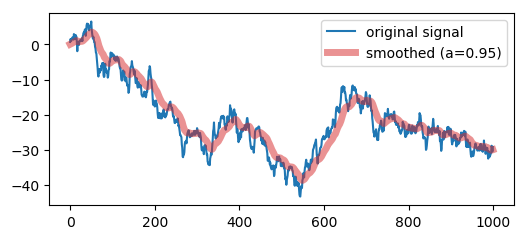

In [8]:
figure(figsize=(6,2.5))

a = 0.95
plot(u)
plot(smooth(u, a), color="C3", lw=5, alpha=0.5)
legend(["original signal", "smoothed (a=$a)"])

savefig("signal_filtering.png", dpi=200, bbox_inches="tight")

## 2) Performance analysis

with the `@time` macro, cf. Julia's manual [Performance tips](https://docs.julialang.org/en/stable/manual/performance-tips/).

NB: there is also `tic()` and `toc()` like in Matlab, but this pair of function is getting deprecated in Julia 0.7.

In [7]:
@time smooth(u, 0.9);

  0.000013 seconds (84 allocations: 14.029 KiB)


Since this time is too short to be meaningful, let's use more points (1M):

In [8]:
srand(0)
u = cumsum(randn(10^7));

In [42]:
@time smooth(u, 0.9);

  0.062617 seconds (6 allocations: 76.294 MiB, 2.01% gc time)


10 Mpts take **~70 ms** to compute, which means ~ 150 Mpts/s

In [40]:
1e7/70e-3/1e6

142.85714285714283

## 3) About the fragility of type inference 😿

This short variant is meant to illustrate a case where Julia's type inference can go wrong and lead to a suboptimal code.

In this variant of the smoothing function, only the final value is kept ($y$ is a scalar, instead of a vector).
`smooth_rt1` and `smooth_rt2` are *almost* the same, but with a factor x10 penalty for `smooth_rt1`.

For 1 Mpts:
* `smooth_rt1`: 212 ms
* `smooth_rt2`:  25 ms

In [26]:
function smooth_rt1(u, a)
    y = 0
    for k=1:length(u)
        y = a*y + (1-a)*u[k]
    end
    return y
end

smooth_rt1 (generic function with 1 method)

In [27]:
smooth_rt1(u, 0.9)

-1733.644404162398

In [28]:
@time smooth_rt1(u, 0.9);

  0.212018 seconds (30.00 M allocations: 457.764 MiB, 10.39% gc time)


In [29]:
function smooth_rt2(u, a)
    y = 0.
    for k=1:length(u)
        y = a*y + (1-a)*u[k]
    end
    return y
end

smooth_rt2 (generic function with 1 method)

In [30]:
smooth_rt2(u, 0.9)

-1733.644404162398

In [31]:
@time smooth_rt2(u, 0.9);

  0.024883 seconds (5 allocations: 176 bytes)


### Dissecting the performance problem

Following advice from the Manual, section [Performance Tips - @code_warntype](https://docs.julialang.org/en/stable/manual/performance-tips/#man-code-warntype-1), I use the `@code_warntype` to uncover the problem. Here, the symptom is a type problem on `y` (`y::Union{Float64, Int64}` instead of `y::Float64`). The cause is the initialization `y=0` instead of `y=0.`

In [32]:
@code_warntype smooth_rt1(u, 0.9);

Variables:
  #self# <optimized out>
  u::Array{Float64,1}
  a::Float64
  k::Int64
  #temp#@_5::Int64
  y::Union{Float64, Int64}
  #temp#@_7::Core.MethodInstance
  #temp#@_8::Float64

Body:
  begin 
      y::Union{Float64, Int64} = 0 # line 3:
      SSAValue(2) = (Base.arraylen)(u::Array{Float64,1})::Int64
      SSAValue(3) = (Base.select_value)((Base.sle_int)(1, SSAValue(2))::Bool, SSAValue(2), (Base.sub_int)(1, 1)::Int64)::Int64
      #temp#@_5::Int64 = 1
      6: 
      unless (Base.not_int)((#temp#@_5::Int64 === (Base.add_int)(SSAValue(3), 1)::Int64)::Bool)::Bool goto 31
      SSAValue(4) = #temp#@_5::Int64
      SSAValue(5) = (Base.add_int)(#temp#@_5::Int64, 1)::Int64
      k::Int64 = SSAValue(4)
      #temp#@_5::Int64 = SSAValue(5) # line 4:
      unless (y::Union{Float64, Int64} isa Int64)::Bool goto 16
      #temp#@_7::Core.MethodInstance = MethodInstance for *(::Float64, ::Int64)
      goto 25
      16: 
      unless (y::Union{Float64, Int64} isa Float64)::Bool goto 20
      #t

In [33]:
@code_warntype smooth_rt2(u, 0.9);

Variables:
  #self# <optimized out>
  u::Array{Float64,1}
  a::Float64
  k::Int64
  #temp#::Int64
  y::Float64

Body:
  begin 
      y::Float64 = 0.0 # line 3:
      SSAValue(2) = (Base.arraylen)(u::Array{Float64,1})::Int64
      SSAValue(3) = (Base.select_value)((Base.sle_int)(1, SSAValue(2))::Bool, SSAValue(2), (Base.sub_int)(1, 1)::Int64)::Int64
      #temp#::Int64 = 1
      6: 
      unless (Base.not_int)((#temp#::Int64 === (Base.add_int)(SSAValue(3), 1)::Int64)::Bool)::Bool goto 16
      SSAValue(4) = #temp#::Int64
      SSAValue(5) = (Base.add_int)(#temp#::Int64, 1)::Int64
      k::Int64 = SSAValue(4)
      #temp#::Int64 = SSAValue(5) # line 4:
      y::Float64 = (Base.add_float)((Base.mul_float)(a::Float64, y::Float64)::Float64, (Base.mul_float)((Base.sub_float)((Base.sitofp)(Float64, 1)::Float64, a::Float64)::Float64, (Base.arrayref)(u::Array{Float64,1}, k::Int64)::Float64)::Float64)::Float64
      14: 
      goto 6
      16:  # line 6:
      return y::Float64
  end::Float64


## Performance Annotations

cf. [Performance Annotations](https://docs.julialang.org/en/stable/manual/performance-tips/#Performance-Annotations-1) section in "Performance Tips"

In [34]:
function smooth_annot(u, a)
    y = zeros(u)
    
    y[1] = (1-a)*u[1]
    @simd for k=2:length(u)
        @inbounds y[k] = a*y[k-1] + (1-a)*u[k]
    end
    
    return y
end

smooth_annot (generic function with 1 method)

In [35]:
length(smooth_annot(u, 0.9))

10000000

In [39]:
@time smooth_annot(u, 0.9);

  0.050563 seconds (6 allocations: 76.294 MiB, 8.04% gc time)


Conclusion: maybe it is a bit better with annotations (50 ms), but it is not completely clear